Mean Squared Error (moyenne) : 0.00
R² Score (moyenne) : -0.24


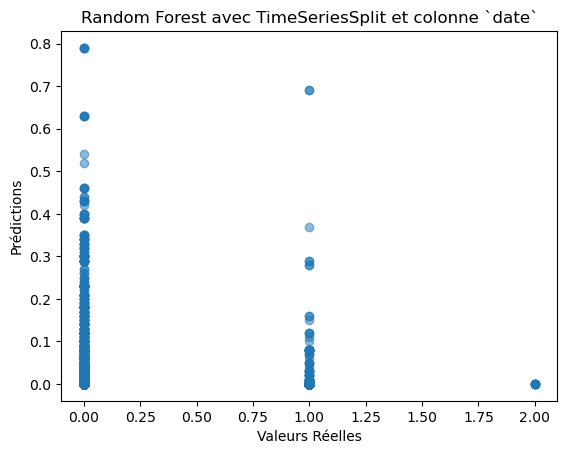

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Charger le dataset
file_path = "/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/datasets_projet/accidents_77_final.csv"
df = pd.read_csv(file_path)

# ✅ **Vérifier que `date` est bien en format datetime**
df['date'] = pd.to_datetime(df['date'])

# ✅ **Extraire des nouvelles features temporelles**
df['dayofweek'] = df['date'].dt.dayofweek  # Jour de la semaine (0=lundi, 6=dimanche)
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)  # Weekend = 1, sinon 0
df['is_holiday_period'] = df['jour_ferie'] | df['vacances_Zone_A'] | df['vacances_Zone_B'] | df['vacances_Zone_C']  # Fusion des jours de vacances

# ✅ **Tri par date pour respecter la chronologie**
df = df.sort_values(by='date')

# ✅ **Mise à jour des features**
features = [
    'com', 'dayofweek', 'is_weekend', 'is_holiday_period',  
    'temp', 'feels_like', 'temp_min', 'temp_max', 
    'pressure', 'humidity', 'wind_speed', 'clouds_all'
]
target = 'nombre_d_accidents'

X = df[features].copy()
y = df[target].copy()

# ✅ **Encodage des variables booléennes**
bool_cols = ['is_weekend', 'is_holiday_period']
X[bool_cols] = X[bool_cols].astype(bool).astype(int)

# ✅ **Identifier les types de variables**
num_features = ['dayofweek', 'temp', 'feels_like', 'temp_min', 'temp_max', 
                'pressure', 'humidity', 'wind_speed', 'clouds_all']
cat_features = ['com']  # Encodage des communes

# ✅ **Pipeline de transformation des données**
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),  # Standardisation des variables numériques
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encodage des communes
])

# ✅ **Création des poids inverses pour équilibrer les valeurs rares**
class_weights = df['nombre_d_accidents'].value_counts(normalize=True).to_dict()
sample_weights = df['nombre_d_accidents'].map(lambda x: 1 / class_weights[x])

# ✅ **🚀 TimeSeriesSplit pour respecter la chronologie**
tscv = TimeSeriesSplit(n_splits=5)

# ✅ **Liste pour stocker les résultats**
mse_list, r2_list = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    weights_train = sample_weights.iloc[train_index]
    
    # ✅ **Passage à un modèle robuste : Random Forest**
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # ✅ **Entraînement du modèle avec pondération**
    model_pipeline.fit(X_train, y_train, regressor__sample_weight=weights_train)

    # ✅ **Prédictions**
    y_pred = model_pipeline.predict(X_test)

    # ✅ **Évaluation du modèle**
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_list.append(mse)
    r2_list.append(r2)

# ✅ **Moyenne des performances sur les splits temporels**
print(f"Mean Squared Error (moyenne) : {np.mean(mse_list):.2f}")
print(f"R² Score (moyenne) : {np.mean(r2_list):.2f}")

# ✅ **Dernière prédiction pour visualisation**
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.title("Random Forest avec TimeSeriesSplit et colonne `date`")
plt.show()


In [32]:
import pandas as pd
import pickle 

df = pd.read_csv('/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/datasets_projet/accidents_77_final.csv')
df["accident"] = df["nombre_d_accidents"].apply(lambda x: False if x == 0 else 1)
df.drop(columns=["nombre_d_accidents"], inplace=True)
df.drop(columns=["jour", "mois", "an"], inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday  # Lundi = 0, Dimanche = 6
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)  # 1 si samedi/dimanche
df.drop(columns=["date"], inplace=True)
bool_cols = ["jour_ferie", "vacances_Zone_A", "vacances_Zone_B", "vacances_Zone_C", "accident"]
df[bool_cols] = df[bool_cols].astype(int)
commune_mapping = {com: idx for idx, com in enumerate(df["com"].unique())}
df["com"] = df["com"].map(commune_mapping)

# Sauvegarde du mapping pour une réutilisation ultérieure
with open("commune_mapping.pkl", "wb") as f:
    pickle.dump(commune_mapping, f)


df

,com,jour_ferie,vacances_Zone_A,vacances_Zone_B,vacances_Zone_C,dep,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,accident,year,month,day,weekday,weekend
0,0,1,1,1,1,77,8.610000,7.160833,5.34,14.29,1024.541667,94.625000,2.794583,59.666667,0,2022,1,1,5,1
1,1,1,1,1,1,77,8.610000,7.160833,5.34,14.29,1024.541667,94.625000,2.794583,59.666667,0,2022,1,1,5,1
2,0,1,1,1,1,77,8.610000,7.160833,5.34,14.29,1024.541667,94.625000,2.794583,59.666667,0,2022,1,1,5,1
3,2,1,1,1,1,77,8.610000,7.160833,5.34,14.29,1024.541667,94.625000,2.794583,59.666667,0,2022,1,1,5,1
4,3,1,1,1,1,77,8.610000,7.160833,5.34,14.29,1024.541667,94.625000,2.794583,59.666667,0,2022,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370105,9,0,1,1,1,77,8.809583,5.634583,6.72,10.84,1003.583333,84.583333,7.989583,74.000000,0,2023,12,31,6,1
370106,23,0,1,1,1,77,8.809583,5.634583,6.72,10.84,1003.583333,84.583333,7.989583,74.000000,0,2023,12,31,6,1
370107,42,0,1,1,1,77,8.809583,5.634583,6.72,10.84,1003.583333,84.583333,7.989583,74.000000,0,2023,12,31,6,1
370108,120,0,1,1,1,77,8.809583,5.634583,6.72,10.84,1003.583333,84.583333,7.989583,74.000000,0,2023,12,31,6,1


<Axes: xlabel='weekday'>

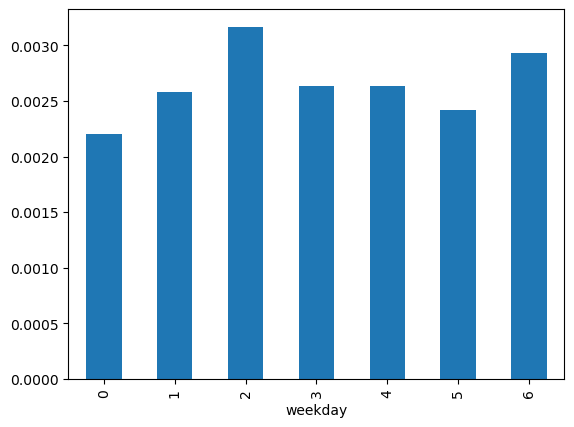

In [8]:
df.groupby("weekday")["accident"].mean().plot(kind="bar")


<Axes: xlabel='month'>

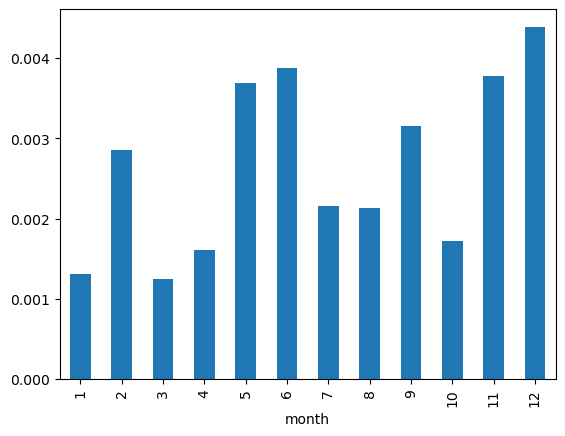

In [9]:
df.groupby("month")["accident"].mean().plot(kind="bar")


<Axes: xlabel='jour_ferie'>

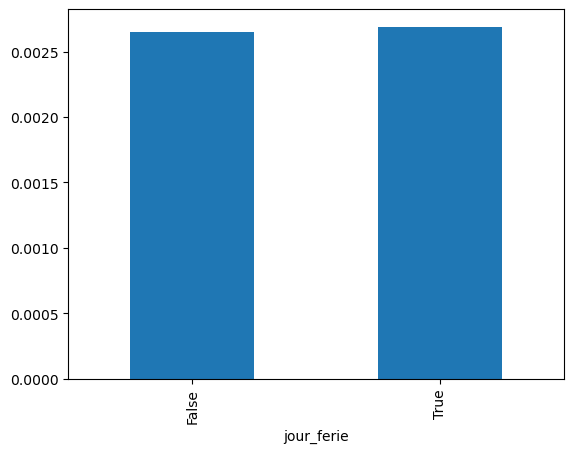

In [10]:
df.groupby("jour_ferie")["accident"].mean().plot(kind="bar")


In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from collections import Counter

df = pd.read_csv('/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/datasets_projet/accidents_77_final.csv')
df["accident"] = df["nombre_d_accidents"].apply(lambda x: False if x == 0 else 1)
df.drop(columns=["nombre_d_accidents"], inplace=True)
df.drop(columns=["jour", "mois", "an"], inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday  # Lundi = 0, Dimanche = 6
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)  # 1 si samedi/dimanche
df.drop(columns=["date"], inplace=True)
bool_cols = ["jour_ferie", "vacances_Zone_A", "vacances_Zone_B", "vacances_Zone_C", "accident"]
df[bool_cols] = df[bool_cols].astype(int)
commune_mapping = {com: idx for idx, com in enumerate(df["com"].unique())}
df["com"] = df["com"].map(commune_mapping)

# 🔹 Définir la target et les features
y = df["accident"]  # Target
X = df.drop(columns=["accident"])  # Features

# 🔹 Séparer en train/test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calcul du ratio entre classes
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]  # Ratio des classes

# 🔹 Création du modèle XGBoost avec gestion du déséquilibre
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # ⚠️ Correction du déséquilibre
    random_state=42
)

# 🔹 Entraînement du modèle
model.fit(X_train, y_train)

# 🔹 Prédictions sous forme de probabilités
y_proba = model.predict_proba(X_test)[:,1]  # Probabilité que ce soit un accident

optimal_threshold = 0.8  
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# 🔹 Nouvelle évaluation des performances
accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# 🔹 Affichage des résultats avec le seuil ajusté
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Matrice de confusion:\n", conf_matrix)



✅ Accuracy: 0.9938
✅ F1 Score: 0.3353
✅ Matrice de confusion:
 [[73446   380]
 [   80   116]]


In [2]:
import os
import pickle

# Définir le chemin du dossier et du fichier
model_dir = "/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/models"
model_path = os.path.join(model_dir, "xgboost_accidents.pkl")

# Vérifier si le dossier existe, sinon le créer
os.makedirs(model_dir, exist_ok=True)

# Sauvegarde du modèle XGBoost
with open(model_path, "wb") as file:
    pickle.dump(model, file)

# Retourner le chemin du fichier sauvegardé
model_path


'/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/models/xgboost_accidents.pkl'

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from collections import Counter

df = pd.read_csv('/Users/maurice/Documents/jedha/jedha/lead/00_projet_lead/datasets_projet/accidents_77_final.csv')
df["accident"] = df["nombre_d_accidents"].apply(lambda x: False if x == 0 else 1)
df.drop(columns=["nombre_d_accidents"], inplace=True)
df.drop(columns=["jour", "mois", "an"], inplace=True)
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday  # Lundi = 0, Dimanche = 6
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)  # 1 si samedi/dimanche
df.drop(columns=["date"], inplace=True)
bool_cols = ["jour_ferie", "vacances_Zone_A", "vacances_Zone_B", "vacances_Zone_C", "accident"]
df[bool_cols] = df[bool_cols].astype(int)

# 🔹 Définir la target et les features
y = df["accident"]  # Target
X = df.drop(columns=["accident"])  # Features

# 🔹 Séparer en train/test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calcul du ratio entre classes
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]  # Ratio des classes

# 🔹 Création du modèle XGBoost avec gestion du déséquilibre
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # ⚠️ Correction du déséquilibre
    random_state=42
)

# 🔹 Entraînement du modèle
model.fit(X_train, y_train)

# 🔹 Prédictions sous forme de probabilités
y_proba = model.predict_proba(X_test)[:,1]  # Probabilité que ce soit un accident

# 🔹 Ajustement du seuil (par défaut 0.5, on le monte à 0.6 ou plus)
optimal_threshold = 0.8  
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# 🔹 Nouvelle évaluation des performances
accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

# 🔹 Affichage des résultats avec le seuil ajusté
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("✅ Matrice de confusion:\n", conf_matrix)


✅ Accuracy: 0.9920
✅ F1 Score: 0.2685
✅ Matrice de confusion:
 [[73319   507]
 [   87   109]]
